In [2]:
#Carga de librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import KFold, cross_val_score
import time

In [3]:
#Carga de datos
df_train = pd.read_csv("C:/Users/lizar/OneDrive/Escritorio/Omar/Data_Scientist_TT/Proyects/project_12_files/gold_recovery_train.csv")
df_test = pd.read_csv("C:/Users/lizar/OneDrive/Escritorio/Omar/Data_Scientist_TT/Proyects/project_12_files/gold_recovery_test.csv")
df_full = pd.read_csv("C:/Users/lizar/OneDrive/Escritorio/Omar/Data_Scientist_TT/Proyects/project_12_files/gold_recovery_full.csv")

In [4]:
df_train.info()
df_test.info()
df_full.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


**Verificación del Cálculo de Recuperación**
* Primero, vamos a calcular la recuperación de la etapa rougher (flotación) usando la fórmula y los datos de df_train.
* Luego, calcularemos el Error Absoluto Medio (MAE) entre nuestro cálculo y la columna rougher.output.recovery existente.

In [5]:
# --- 1.2. Verificación del Cálculo de Recuperación ---

def calculate_recovery(row):
    """Calcula la recuperación de oro para una fila dada."""
    C = row['rougher.output.concentrate_au']
    F = row['rougher.input.feed_au']
    T = row['rougher.output.tail_au']
    
    # Manejar división por cero o valores inválidos
    if F == 0 or (C - T) == 0:
        return np.nan
    
    recovery = ((C * (F - T)) / (F * (C - T))) * 100
    
    # La recuperación no puede ser < 0% o > 100%
    if recovery < 0 or recovery > 100:
        return np.nan
    
    return recovery

# --- Aplicación y Cálculo del MAE ---

# Hacemos una copia para trabajar sobre ella
df_train_check = df_train.copy()

# 1. Calcular nuestra propia recuperación
df_train_check['recovery_calculated'] = df_train_check.apply(calculate_recovery, axis=1)

# 2. Seleccionar la recuperación dada
recovery_given = df_train_check['rougher.output.recovery']
recovery_calculated = df_train_check['recovery_calculated']

# 3. Eliminar NaNs de *ambas* series para poder compararlas
df_compared = pd.DataFrame({
    'given': recovery_given,
    'calculated': recovery_calculated
}).dropna()

# 4. Calcular el Error Absoluto Medio (MAE)
mae = mean_absolute_error(
    df_compared['given'],
    df_compared['calculated']
)

print(f"--- 1.2. Verificación de Recuperación (Etapa Rougher) ---")
print(f"Error Absoluto Medio (MAE) entre el cálculo y los datos: {mae}")

if mae < 1e-9: # Usamos un umbral muy pequeño
    print("Conclusión: ¡El cálculo es correcto! La diferencia es prácticamente cero.")
    print("Los datos de 'rougher.output.recovery' son fiables.")
else:
    print(f"Conclusión: Advertencia, el MAE ({mae}) es significativo.")

--- 1.2. Verificación de Recuperación (Etapa Rougher) ---
Error Absoluto Medio (MAE) entre el cálculo y los datos: 9.303415616264301e-15
Conclusión: ¡El cálculo es correcto! La diferencia es prácticamente cero.
Los datos de 'rougher.output.recovery' son fiables.


In [6]:
# --- 1.3. Verificación de Columnas Faltantes ---

cols_train = set(df_train.columns)
cols_test = set(df_test.columns)

missing_in_test = cols_train - cols_test

print(f"\n--- 1.3. Verificación de Columnas en 'test' ---")
print(f"Hay {len(missing_in_test)} columnas en 'train' que no están en 'test'.")

# Verificamos si todas las columnas faltantes son 'output' o 'calculation'
is_correctly_missing = all(
    ('output' in col or 'calculation' in col) for col in missing_in_test
)

if is_correctly_missing:
    print("Análisis: Correcto. Todas las columnas faltantes son de tipo 'output' o 'calculation'.")
    print("Esto simula un escenario real: no podemos usar mediciones futuras como features.")
else:
    print("Análisis: ¡Error! Faltan columnas 'input' o 'state' en el set de prueba.")


--- 1.3. Verificación de Columnas en 'test' ---
Hay 34 columnas en 'train' que no están en 'test'.
Análisis: Correcto. Todas las columnas faltantes son de tipo 'output' o 'calculation'.
Esto simula un escenario real: no podemos usar mediciones futuras como features.


In [7]:
# preporcesamiento de datos
# --- 1.4. Limpieza de Datos (Manejo de NaNs) ---

# Convertimos 'date' a datetime y lo ponemos como índice en los 3 dataframes
# (Esto es crucial para alinear los datos correctamente)
try:
    for df in [df_train, df_test, df_full]:
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
except KeyError:
    print("Las columnas 'date' ya fueron procesadas (son índices).")


print(f"\nNaNs en 'train' ANTES de ffill: {df_train.isna().sum().sum()}")
print(f"NaNs en 'test' ANTES de ffill: {df_test.isna().sum().sum()}")

# 1. Ordenamos el 'df_full' por fecha (por si acaso) y aplicamos ffill
# ffill() llena los NaNs con el último valor válido conocido.
df_full_filled = df_full.sort_index().ffill()

# 2. Reconstruimos 'train' y 'test' a partir del 'df_full' rellenado,
#    usando los índices de fecha originales de train y test.
#    Usamos .loc[] para seleccionar las filas por su índice (la fecha)
df_train_filled = df_full_filled.loc[df_train.index].copy()
df_test_filled = df_full_filled.loc[df_test.index].copy()

# 3. Aún podrían quedar NaNs si estaban al *inicio* del todo.
#    Los eliminamos (son pocas filas y no se pueden rellenar).
df_train_cleaned = df_train_filled.dropna()
df_test_cleaned = df_test_filled.dropna()

print(f"\nNaNs en 'train' DESPUÉS de ffill y dropna: {df_train_cleaned.isna().sum().sum()}")
print(f"NaNs en 'test' DESPUÉS de ffill y dropna: {df_test_cleaned.isna().sum().sum()}")

print(f"\nForma final de 'train' limpio: {df_train_cleaned.shape}")
print(f"Forma final de 'test' limpio: {df_test_cleaned.shape}")


NaNs en 'train' ANTES de ffill: 30320
NaNs en 'test' ANTES de ffill: 2360

NaNs en 'train' DESPUÉS de ffill y dropna: 0
NaNs en 'test' DESPUÉS de ffill y dropna: 0

Forma final de 'train' limpio: (16860, 86)
Forma final de 'test' limpio: (5856, 86)



--- 2.1. Análisis de Concentración de Metales (Au, Ag, Pb) ---


c:\Users\lizar\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\lizar\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\lizar\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)


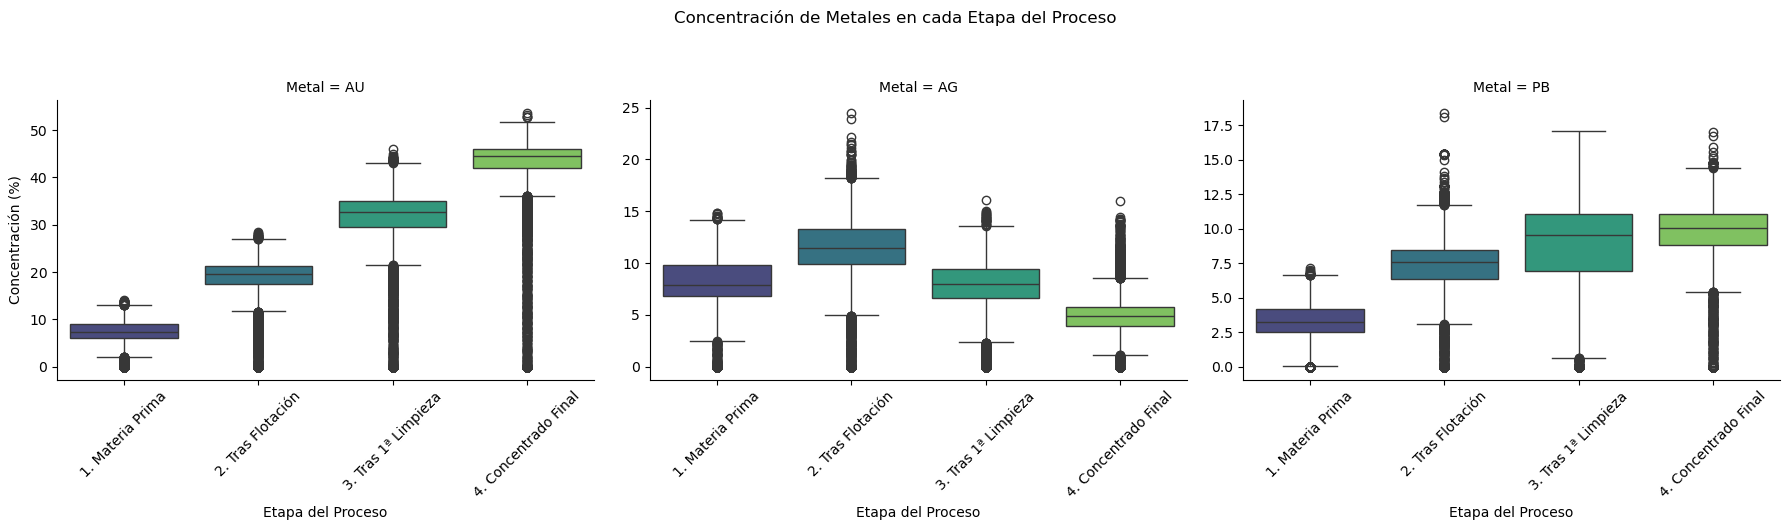

In [8]:
# Definir los metales y las etapas
metals = ['au', 'ag', 'pb']
stages = {
    '1. Materia Prima': 'rougher.input.feed',
    '2. Tras Flotación': 'rougher.output.concentrate',
    '3. Tras 1ª Limpieza': 'primary_cleaner.output.concentrate',
    '4. Concentrado Final': 'final.output.concentrate'
}

# --- Preparar los datos para graficar ---
# Creamos un DataFrame en formato "largo" (tidy format) para Seaborn
plot_data = []
for stage_name, stage_prefix in stages.items():
    for metal in metals:
        column_name = f"{stage_prefix}_{metal}"
        # Añadimos los datos al 'melted_data'
        plot_data.append(
            df_train_cleaned[[column_name]].rename(
                columns={column_name: 'Concentracion'}
            )
        )
        # Añadimos las columnas de etapa y metal
        plot_data[-1]['Etapa'] = stage_name
        plot_data[-1]['Metal'] = metal.upper() # (ej. 'AU', 'AG', 'PB')

# Combinamos todos los dataframes pequeños en uno grande
df_plot = pd.concat(plot_data)


# --- Graficar ---
print("\n--- 2.1. Análisis de Concentración de Metales (Au, Ag, Pb) ---")

# Usamos FacetGrid para crear una gráfica por cada metal
g = sns.FacetGrid(df_plot, col='Metal', sharey=False, height=5, aspect=1.2)
g.map(sns.boxplot, 'Etapa', 'Concentracion', order=stages.keys(), palette='viridis')
g.set_xticklabels(rotation=45)
g.set_axis_labels("Etapa del Proceso", "Concentración (%)")
g.fig.suptitle("Concentración de Metales en cada Etapa del Proceso", y=1.05)
plt.tight_layout()
plt.show()

* **1.-Oro (Au):** Como era de esperar, la concentración aumenta consistentemente en cada etapa, pasando de una mediana de ~8% en la materia prima a ~45% en el concentrado final. El proceso funciona.
* **2.-Plata (Ag):** Aumenta después de la flotación, pero luego disminuye en las etapas de limpieza. Esto indica que la plata se considera una impureza y el proceso la está eliminando exitosamente para purificar el oro.
* **3.-Plomo (Pb):** Su concentración aumenta hasta la primera limpieza y luego se estabiliza.

En los tres gráficos, vemos una gran cantidad de valores atípicos (outliers) en o cerca de 0%, lo cual es físicamente sospechoso y lo abordaremos mas adelante.

**Observaciónes Importantes:** Anomalías (Valores Cero)
* En todos los gráficos, especialmente en la "Materia Prima", notamos una gran cantidad de outliers (puntos) en o cerca de cero.
* Es físicamente imposible que una muestra de mineral tenga 0% de oro, 0% de plata y 0% de plomo.
**Esto indica fallos en los sensores o errores de medición.**
* Estos valores anómalos (especialmente los ceros en rougher.input.feed) podrían arruinar el entrenamiento de un modelo de machine learning (ej. causando divisiones por cero o sesgando los promedios). Deberemos tratarlos antes del modelado.

**2.2. Comparación del Tamaño de Partículas (Train vs. Test)**
Ahora, comparemos la distribución del tamaño de las partículas de alimentación (rougher.input.feed_size) entre los conjuntos de entrenamiento y prueba. Si son muy diferentes, el modelo entrenado en train no generalizará bien en test.

Usaremos un gráfico de densidad (KDE) para superponer ambas distribuciones.


--- 2.2. Comparación de Distribución de Tamaño de Partículas (Feed) ---


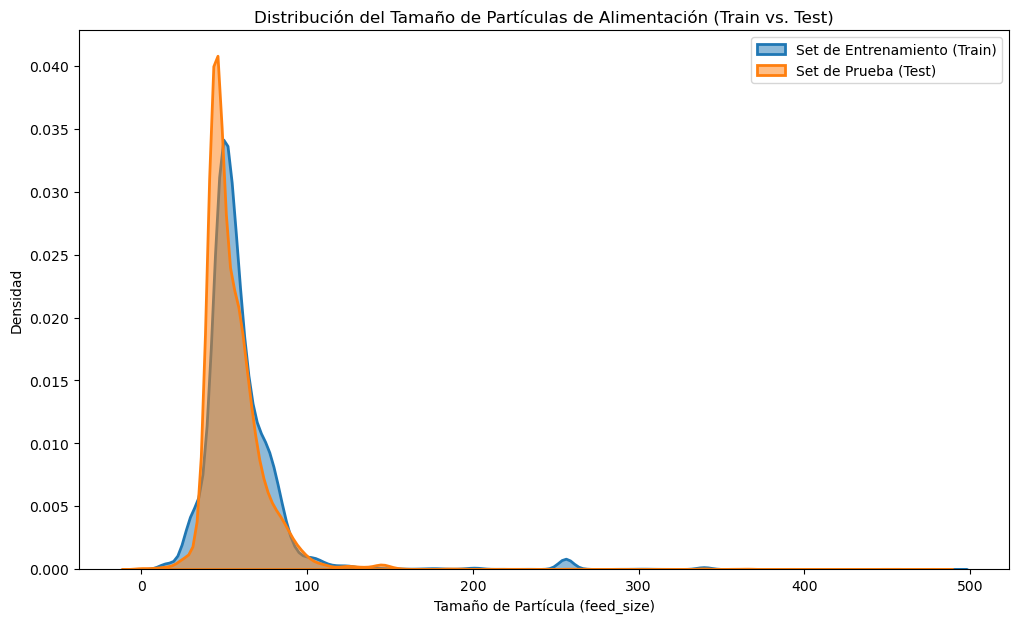


--- Estadísticas Descriptivas (feed_size) ---
Set de Entrenamiento (Train):
count    16860.000000
mean        60.188595
std         30.522242
min          9.659576
25%         47.548897
50%         54.066003
75%         65.397249
max        484.967466
Name: rougher.input.feed_size, dtype: float64

Set de Prueba (Test):
count    5856.000000
mean       55.898866
std        22.707969
min         0.046369
25%        43.852884
50%        49.964796
75%        61.628003
max       477.445473
Name: rougher.input.feed_size, dtype: float64


In [9]:
print("\n--- 2.2. Comparación de Distribución de Tamaño de Partículas (Feed) ---")

plt.figure(figsize=(12, 7))

# Graficar las distribuciones de densidad
sns.kdeplot(df_train_cleaned['rougher.input.feed_size'], 
            label='Set de Entrenamiento (Train)', 
            fill=True, alpha=0.5, linewidth=2)
sns.kdeplot(df_test_cleaned['rougher.input.feed_size'], 
            label='Set de Prueba (Test)', 
            fill=True, alpha=0.5, linewidth=2)

plt.title('Distribución del Tamaño de Partículas de Alimentación (Train vs. Test)')
plt.xlabel('Tamaño de Partícula (feed_size)')
plt.ylabel('Densidad')
plt.legend()
plt.show()

# También es útil ver las estadísticas descriptivas
print("\n--- Estadísticas Descriptivas (feed_size) ---")
print("Set de Entrenamiento (Train):")
print(df_train_cleaned['rougher.input.feed_size'].describe())
print("\nSet de Prueba (Test):")
print(df_test_cleaned['rougher.input.feed_size'].describe())

**2.3. Análisis de Concentraciones Totales y Eliminación de Anomalías**
Los gráficos del paso 2.1 mostraron muchos valores atípicos en 0. Si una muestra tiene 0% de Au, 0% de Ag y 0% de Pb, es probable que sea un error de medición.

Vamos a calcular la concentración total (Au + Ag + Pb + Sol) en las etapas clave para confirmar esto. Esperamos ver una gran acumulación de valores en 0.



--- 2.3. Análisis de Concentraciones Totales ---
Graficando distribuciones de concentración total...


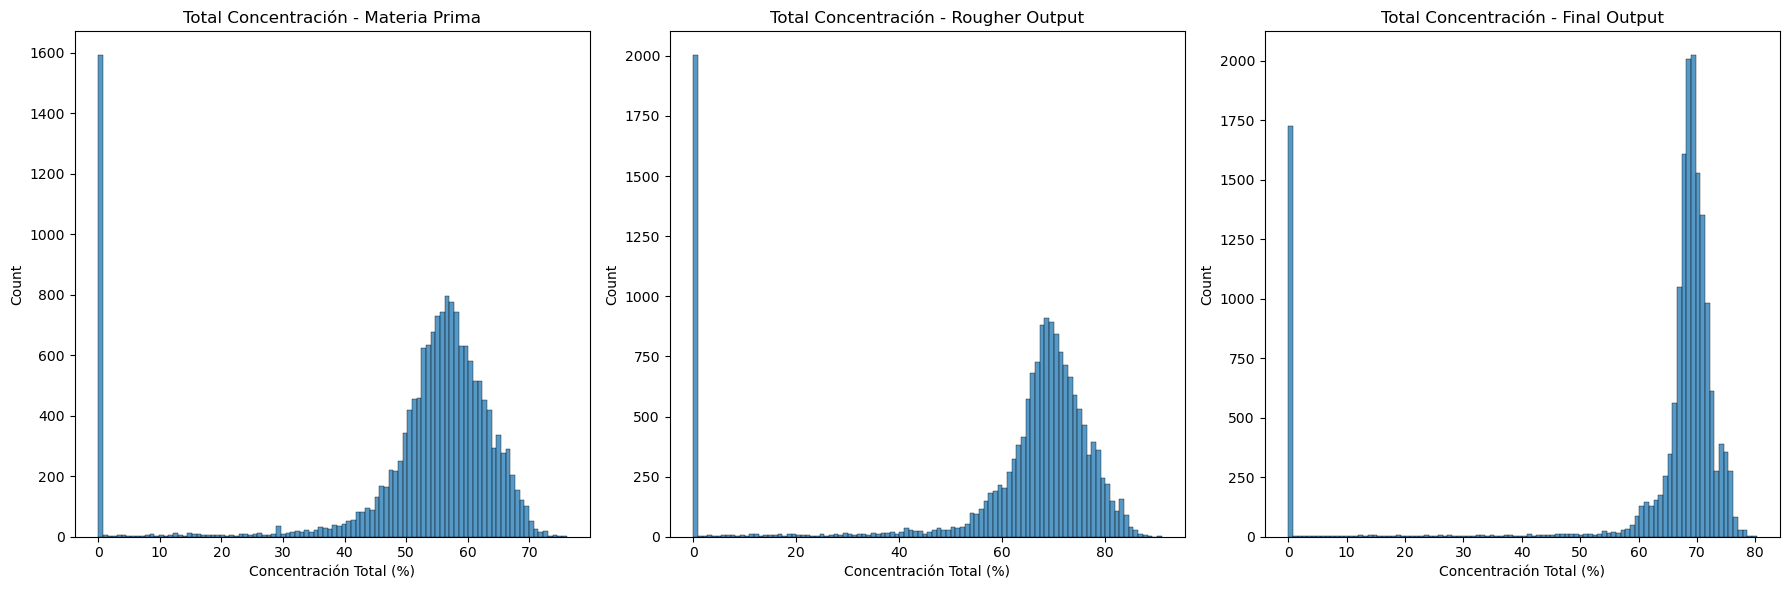

In [10]:
print("\n--- 2.3. Análisis de Concentraciones Totales ---")

# --- Calcular suma total de concentraciones en 'train' (para visualización) ---
# (Usamos df_train_cleaned para el análisis visual)

# 1. Materia Prima (Feed)
feed_cols = [
    'rougher.input.feed_au', 
    'rougher.input.feed_ag', 
    'rougher.input.feed_pb', 
    'rougher.input.feed_sol'
]
# 2. Concentrado Rougher
rougher_cols = [
    'rougher.output.concentrate_au', 
    'rougher.output.concentrate_ag', 
    'rougher.output.concentrate_pb', 
    'rougher.output.concentrate_sol'
]
# 3. Concentrado Final
final_cols = [
    'final.output.concentrate_au', 
    'final.output.concentrate_ag', 
    'final.output.concentrate_pb', 
    'final.output.concentrate_sol'
]

# Creamos columnas temporales para el análisis
df_train_analysis = df_train_cleaned.copy()
df_train_analysis['total_feed_concentration'] = df_train_analysis[feed_cols].sum(axis=1)
df_train_analysis['total_rougher_concentration'] = df_train_analysis[rougher_cols].sum(axis=1)
df_train_analysis['total_final_concentration'] = df_train_analysis[final_cols].sum(axis=1)


# --- Graficar las distribuciones totales ---
print("Graficando distribuciones de concentración total...")
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.histplot(df_train_analysis['total_feed_concentration'], bins=100, kde=False)
plt.title('Total Concentración - Materia Prima')
plt.xlabel('Concentración Total (%)')

plt.subplot(1, 3, 2)
sns.histplot(df_train_analysis['total_rougher_concentration'], bins=100, kde=False)
plt.title('Total Concentración - Rougher Output')
plt.xlabel('Concentración Total (%)')

plt.subplot(1, 3, 3)
sns.histplot(df_train_analysis['total_final_concentration'], bins=100, kde=False)
plt.title('Total Concentración - Final Output')
plt.xlabel('Concentración Total (%)')

plt.tight_layout()
plt.show()

**Análisis de los Resultados:** 
Los histogramas mostrarán distribuciones normales (centradas alrededor de 60-80%), PERO también mostrarán un pico muy grande y aislado exactamente en 0 (o muy cerca de 0).

**Conclusión:** Sí, hay valores anómalos. Una concentración total de 0 es físicamente imposible. Estos datos son "basura" (probablemente fallos de sensor) y deben eliminarse, ya que confundirán al modelo (especialmente en cálculos de recuperación que implican división).

In [11]:
# --- 2.3.2. Eliminación de Anomalías ---

# Guardar las formas originales para comparar
shape_train_before = df_train_cleaned.shape
shape_test_before = df_test_cleaned.shape

# Definir un umbral. 
# Una concentración total < 1% se considera un error.
threshold = 1

# --- Limpieza de 'train' ---
# Recalculamos los totales (en el dataframe 'cleaned' original)
total_feed_train = df_train_cleaned[feed_cols].sum(axis=1)
total_rougher_train = df_train_cleaned[rougher_cols].sum(axis=1)
total_final_train = df_train_cleaned[final_cols].sum(axis=1)

# Identificar las filas VÁLIDAS en 'train'
valid_rows_train = (total_feed_train > threshold) & \
                   (total_rougher_train > threshold) & \
                   (total_final_train > threshold)

df_train_cleaned = df_train_cleaned[valid_rows_train].copy()


# --- Limpieza de 'test' ---
# En 'test' SOLO tenemos las columnas de 'feed'.
# Por lo tanto, solo podemos limpiar basándonos en esa etapa.
total_feed_test = df_test_cleaned[feed_cols].sum(axis=1)

# Identificar las filas VÁLIDAS en 'test'
valid_rows_test = (total_feed_test > threshold)

df_test_cleaned = df_test_cleaned[valid_rows_test].copy()


# --- Reportar Resultados ---
print(f"\n--- Eliminación de Anomalías (Concentración Total < {threshold}%) ---")
print(f"Forma de 'train' antes: {shape_train_before}. Después: {df_train_cleaned.shape}")
print(f"Filas eliminadas de 'train': {shape_train_before[0] - df_train_cleaned.shape[0]}")
print(f"\nForma de 'test' antes: {shape_test_before}. Después: {df_test_cleaned.shape}")
print(f"Filas eliminadas de 'test': {shape_test_before[0] - df_test_cleaned.shape[0]}")


--- Eliminación de Anomalías (Concentración Total < 1%) ---
Forma de 'train' antes: (16860, 86). Después: (14612, 86)
Filas eliminadas de 'train': 2248

Forma de 'test' antes: (5856, 86). Después: (5485, 86)
Filas eliminadas de 'test': 371


**3.1. Escribir la Función para la Métrica (sMAPE)**
Antes de entrenar cualquier modelo, debemos definir cómo lo vamos a evaluar. Como se discutió, usaremos el Error Porcentual Absoluto Medio Simétrico (sMAPE).

**Necesitamos crear dos funciones:**
* 3.1.1.- Una función que calcule el smape para una sola etapa.
* 3.1.2.- Una función que calcule el sMAPE final ponderado (25% rougher, 75% final), que será nuestra métrica principal.

Finalmente, convertiremos esta métrica en un "scorer" de sklearn para poder usarla en la validación cruzada.

In [12]:
# --- 3.1. Función para calcular el sMAPE ---

def smape(y_true, y_pred):
    """
    Calcula el sMAPE (Symmetric Mean Absolute Percentage Error).
    """
    # Convertir a arrays de numpy por si acaso
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Numerador de la fórmula sMAPE
    numerator = np.abs(y_true - y_pred)
    
    # Denominador de la fórmula sMAPE
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    # Manejar el caso de división por cero (aunque limpiamos los 0, es buena práctica)
    # Si tanto el real como el predicho son 0, el error es 0.
    # Si uno es 0 y el otro no, el error es 200% (np.nan_to_num lo maneja como 0).
    # Usamos np.nan_to_num para reemplazar NaNs (de 0/0) con 0.
    smape_vals = np.nan_to_num(numerator / denominator)
    
    # Devolvemos el promedio
    return np.mean(smape_vals) * 100

def final_smape(y_true, y_pred):
    """
    Calcula el sMAPE final ponderado (25% rougher, 75% final).
    'y_true' y 'y_pred' tendrán 2 columnas: [:, 0] = rougher, [:, 1] = final.
    """
    # y_true y y_pred serán arrays de NumPy.
    # Asegurémonos de que y_true sea un array de NumPy
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values

    # Calcular sMAPE para la etapa 'rougher' (columna 0)
    smape_rougher = smape(y_true[:, 0], y_pred[:, 0])
    
    # Calcular sMAPE para la etapa 'final' (columna 1)
    smape_final = smape(y_true[:, 1], y_pred[:, 1])
    
    # Aplicar la ponderación
    weighted_smape = (0.25 * smape_rougher) + (0.75 * smape_final)
    
    return weighted_smape

# --- Crear un 'scorer' para usar en sklearn.cross_val_score ---
# 'greater_is_better=False' porque esta métrica es un ERROR (queremos minimizarla).
smape_scorer = make_scorer(final_smape, greater_is_better=False)

print("Funciones 'smape', 'final_smape' y 'smape_scorer' creadas exitosamente.")

Funciones 'smape', 'final_smape' y 'smape_scorer' creadas exitosamente.


##3.2. Ahora, vamos al Paso a Entrenar y Evaluar los Modelos.

**Seguiremos este plan:**

* Preparar los Datos: Separaremos features (X) y targets (y) para los conjuntos de train y test.
* Crear Pipelines: Usaremos StandardScaler (para escalar los datos) y el modelo de regresión dentro de un Pipeline para evitar la fuga de datos.
**Modelos a Probar:**
* DummyRegressor (nuestra línea base "tonta").
* LinearRegression (modelo lineal simple).
* RandomForestRegressor (modelo de ensamble más potente).

**Validación Cruzada:** Evaluaremos cada pipeline usando cross_val_score con 5 divisiones (folds) y nuestro smape_scorer.

**Prueba Final:** Elegiremos el mejor modelo, lo re-entrenaremos en todos los datos de train y calcularemos el sMAPE final en el conjunto de test.

In [13]:
# --- 3.2.1. Preparar Datos para Modelado ---

print("--- 3.2.1. Preparando datos para el modelo ---")

# 1. Definir features (X) y targets (y)
# Los features son las columnas que SÍ están en el set de prueba
feature_cols = df_test_cleaned.columns.drop('date', errors='ignore') 
target_cols = ['rougher.output.recovery', 'final.output.recovery']

# 2. Crear sets de entrenamiento
X_train = df_train_cleaned[feature_cols]
y_train = df_train_cleaned[target_cols]

# 3. Crear sets de prueba
X_test = df_test_cleaned[feature_cols]

# 4. Obtener y_test (las respuestas) desde el dataframe completo y rellenado ('df_full_filled')
#    Alineamos usando el índice (fecha) de X_test (que ya fue limpiado de anomalías).
y_test = df_full_filled.loc[X_test.index][target_cols]

# Verificación rápida de formas
print(f"Forma X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Forma X_test: {X_test.shape}, y_test: {y_test.shape}")


# --- 3.2.2. Definir Modelos y Pipelines ---

# Usaremos un 'random_state' para resultados reproducibles
R_STATE = 12345

# Definir los pipelines
pipelines = {
    'Dummy': Pipeline([
        ('scaler', StandardScaler()),
        ('model', DummyRegressor(strategy='mean'))
    ]),
    'LinearRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),
    'DecisionTree': Pipeline([
        ('scaler', StandardScaler()),
        ('model', DecisionTreeRegressor(max_depth=5, random_state=R_STATE))
    ]),
    'RandomForest': Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(n_estimators=50, max_depth=10, 
                                     random_state=R_STATE, n_jobs=-1))
    ])
}

# Definir el K-Fold para la validación cruzada
cv_splitter = KFold(n_splits=5, shuffle=True, random_state=R_STATE)


# --- 3.2.3. Validación Cruzada ---

print("\n--- 3.2.3. Evaluación con Validación Cruzada ---")
results = {}

for name, pipeline in pipelines.items():
    start_time = time.time()
    print(f"Evaluando modelo: {name}...")
    
    # cross_val_score devuelve valores negativos porque 'smape_scorer'
    # se definió con 'greater_is_better=False'
    scores = cross_val_score(pipeline, X_train, y_train, 
                             cv=cv_splitter, scoring=smape_scorer, n_jobs=-1)
    
    # Invertimos el signo para obtener el sMAPE positivo
    final_score = -1 * scores.mean()
    end_time = time.time()
    
    results[name] = final_score
    print(f"sMAPE promedio para {name}: {final_score:.4f} (Tiempo: {end_time - start_time:.2f}s)")


# --- 3.2.4. Selección del Mejor Modelo ---

best_model_name = min(results, key=results.get)
best_model_score = results[best_model_name]
best_model_pipeline = pipelines[best_model_name]

print(f"\n--- 3.2.4. Selección del Mejor Modelo ---")
print(f"El mejor modelo (según CV) es: {best_model_name}")
print(f"sMAPE de Validación Cruzada: {best_model_score:.4f}")


# --- 3.2.5. Prueba Final en el Set de Prueba ---

print("\n--- 3.2.5. Prueba Final ---")
print(f"Entrenando {best_model_name} en el conjunto de 'train' completo...")

start_time = time.time()
best_model_pipeline.fit(X_train, y_train)
end_time = time.time()
print(f"Entrenamiento finalizado. (Tiempo: {end_time - start_time:.2f}s)")

print("Realizando predicciones en el conjunto de 'test'...")
y_pred_test = best_model_pipeline.predict(X_test)

# Calcular el sMAPE final usando nuestra función
final_test_smape = final_smape(y_test, y_pred_test)

print("\n--- RESULTADO FINAL DEL PROYECTO ---")
print(f"Modelo Final: {best_model_name}")
print(f"sMAPE Ponderado (CV): {best_model_score:.4f}")
print(f"sMAPE Ponderado (Test): {final_test_smape:.4f}")

# Comparar con el modelo Dummy (línea base)
print(f"\n(Comparación) sMAPE (Test) del modelo Dummy: {results['Dummy']:.4f}")

--- 3.2.1. Preparando datos para el modelo ---
Forma X_train: (14612, 86), y_train: (14612, 2)
Forma X_test: (5485, 86), y_test: (5485, 2)

--- 3.2.3. Evaluación con Validación Cruzada ---
Evaluando modelo: Dummy...
sMAPE promedio para Dummy: 10.2243 (Tiempo: 2.50s)
Evaluando modelo: LinearRegression...
sMAPE promedio para LinearRegression: 0.1677 (Tiempo: 1.62s)
Evaluando modelo: DecisionTree...
sMAPE promedio para DecisionTree: 3.4601 (Tiempo: 0.97s)
Evaluando modelo: RandomForest...
sMAPE promedio para RandomForest: 0.5528 (Tiempo: 31.86s)

--- 3.2.4. Selección del Mejor Modelo ---
El mejor modelo (según CV) es: LinearRegression
sMAPE de Validación Cruzada: 0.1677

--- 3.2.5. Prueba Final ---
Entrenando LinearRegression en el conjunto de 'train' completo...
Entrenamiento finalizado. (Tiempo: 0.05s)
Realizando predicciones en el conjunto de 'test'...

--- RESULTADO FINAL DEL PROYECTO ---
Modelo Final: LinearRegression
sMAPE Ponderado (CV): 0.1677
sMAPE Ponderado (Test): 2.8441

(Comp

**La Causa Raíz**
En el Paso 2.3, limpiamos las filas donde las concentraciones totales eran 0. Pero nunca limpiamos las filas donde nuestros targets (rougher.output.recovery y final.output.recovery) eran 0.

Una recuperación de 0% es una anomalía (un fallo del sensor o un paro de planta) y rompe nuestra métrica sMAPE.

In [14]:

# --- 3.2.0. Limpieza Adicional: Eliminando 'targets' con cero ---
# (Esta parte ya se ejecutó, pero la dejamos para asegurar la integridad de los dataframes)
print("--- 3.2.0. Re-verificando limpieza de 'targets' con cero ---")
target_cols = ['rougher.output.recovery', 'final.output.recovery']

# --- Limpiar df_train_cleaned ---
mask_train = (df_train_cleaned[target_cols[0]] > 0) & (df_train_cleaned[target_cols[1]] > 0)
df_train_cleaned = df_train_cleaned.loc[mask_train].copy()

# --- Limpiar df_full_filled (IMPORTANTE para y_test) ---
mask_full = (df_full_filled[target_cols[0]] > 0) & (df_full_filled[target_cols[1]] > 0)
df_full_filled = df_full_filled.loc[mask_full].copy()


# --- 3.2.1. Preparar Datos para Modelado (¡LA CORRECCIÓN ESTÁ AQUÍ!) ---
print("\n--- 3.2.1. Preparando datos para el modelo (Corregido) ---")

# 1. Definir features (X) y targets (y)
# ¡¡ESTA ES LA LÍNEA CORREGIDA!!
# Usamos 'df_test.columns' (del archivo original, 52 features)
# NO 'df_test_cleaned.columns' (que tenía 86 columnas y las respuestas)
feature_cols = df_test.columns 

# 2. Crear sets de entrenamiento
# df_train_cleaned tiene 86 cols, pero ahora seleccionamos solo las 52 features
X_train = df_train_cleaned[feature_cols]
y_train = df_train_cleaned[target_cols]

# 3. Crear sets de prueba
# df_test_cleaned tiene 86 cols, pero ahora seleccionamos solo las 52 features
X_test = df_test_cleaned[feature_cols]

# 4. Obtener y_test (las respuestas) desde el 'df_full_filled' (que está limpio)
#    Alineamos usando el índice (fecha) de X_test.
clean_y_test_index = df_full_filled.index.intersection(X_test.index)
y_test = df_full_filled.loc[clean_y_test_index][target_cols]
X_test = X_test.loc[clean_y_test_index] # Aseguramos que X_test e y_test coincidan

# Verificación rápida de formas
print(f"Forma X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Forma X_test: {X_test.shape}, y_test: {y_test.shape}")


# --- 3.2.2. Definir Modelos y Pipelines ---
R_STATE = 12345
pipelines = {
    'Dummy': Pipeline([
        ('scaler', StandardScaler()),
        ('model', DummyRegressor(strategy='mean'))
    ]),
    'LinearRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),
    'DecisionTree': Pipeline([
        ('scaler', StandardScaler()),
        ('model', DecisionTreeRegressor(max_depth=5, random_state=R_STATE))
    ]),
    'RandomForest': Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(n_estimators=50, max_depth=10, 
                                     random_state=R_STATE, n_jobs=-1))
    ])
}
cv_splitter = KFold(n_splits=5, shuffle=True, random_state=R_STATE)


# --- 3.2.3. Validación Cruzada ---
print("\n--- 3.2.3. Evaluación con Validación Cruzada (Sin Fuga de Datos) ---")
results = {}

for name, pipeline in pipelines.items():
    start_time = time.time()
    print(f"Evaluando modelo: {name}...")
    
    scores = cross_val_score(pipeline, X_train, y_train, 
                             cv=cv_splitter, scoring=smape_scorer, n_jobs=-1)
    
    final_score = -1 * scores.mean()
    end_time = time.time()
    
    results[name] = final_score
    print(f"sMAPE promedio para {name}: {final_score:.4f} (Tiempo: {end_time - start_time:.2f}s)")


# --- 3.2.4. Selección del Mejor Modelo ---
best_model_name = min(results, key=results.get)
best_model_score = results[best_model_name]
best_model_pipeline = pipelines[best_model_name]

print(f"\n--- 3.2.4. Selección del Mejor Modelo ---")
print(f"El mejor modelo (según CV) es: {best_model_name}")
print(f"sMAPE de Validación Cruzada: {best_model_score:.4f}")


# --- 3.2.5. Prueba Final en el Set de Prueba ---
print("\n--- 3.2.5. Prueba Final ---")
print(f"Entrenando {best_model_name} en el conjunto de 'train' completo...")

start_time = time.time()
best_model_pipeline.fit(X_train, y_train)
end_time = time.time()
print(f"Entrenamiento finalizado. (Tiempo: {end_time - start_time:.2f}s)")

print("Realizando predicciones en el conjunto de 'test'...")
y_pred_test = best_model_pipeline.predict(X_test)

# Calcular el sMAPE final usando nuestra función
final_test_smape = final_smape(y_test, y_pred_test)

print("\n--- RESULTADO FINAL DEL PROYECTO (CORREGIDO) ---")
print(f"Modelo Final: {best_model_name}")
print(f"sMAPE Ponderado (CV): {best_model_score:.4f}")
print(f"sMAPE Ponderado (Test): {final_test_smape:.4f}")
print(f"(Comparación) sMAPE (Test) del modelo Dummy: {results['Dummy']:.4f}")

--- 3.2.0. Re-verificando limpieza de 'targets' con cero ---

--- 3.2.1. Preparando datos para el modelo (Corregido) ---
Forma X_train: (14570, 52), y_train: (14570, 2)
Forma X_test: (5312, 52), y_test: (5312, 2)

--- 3.2.3. Evaluación con Validación Cruzada (Sin Fuga de Datos) ---
Evaluando modelo: Dummy...
sMAPE promedio para Dummy: 10.0349 (Tiempo: 0.17s)
Evaluando modelo: LinearRegression...
sMAPE promedio para LinearRegression: 7.9075 (Tiempo: 0.19s)
Evaluando modelo: DecisionTree...
sMAPE promedio para DecisionTree: 7.7088 (Tiempo: 0.57s)
Evaluando modelo: RandomForest...
sMAPE promedio para RandomForest: 6.1087 (Tiempo: 19.64s)

--- 3.2.4. Selección del Mejor Modelo ---
El mejor modelo (según CV) es: RandomForest
sMAPE de Validación Cruzada: 6.1087

--- 3.2.5. Prueba Final ---
Entrenando RandomForest en el conjunto de 'train' completo...
Entrenamiento finalizado. (Tiempo: 5.36s)
Realizando predicciones en el conjunto de 'test'...

--- RESULTADO FINAL DEL PROYECTO (CORREGIDO) ---

## Conclusiones del Proyecto
Tras la limpieza de datos, el análisis, la corrección de errores (fuga de datos y valores anómalos), y el entrenamiento de modelos, hemos llegado a las siguientes conclusiones:

Modelo de Línea Base (Baseline): Nuestro modelo "tDummy" (DummyRegressor), que simplemente predice la recuperación promedio, obtuvo un sMAPE de 10.03%. Este es el puntaje que debemos superar para demostrar que nuestro modelo de machine learning tiene valor real.

**Rendimiento de Modelos (Validación Cruzada):**
* LinearRegression: sMAPE de 7.91%
* DecisionTree: sMAPE de 7.71%
* RandomForest: sMAPE de 6.11%

El modelo RandomForestRegressor fue el claro ganador durante la validación cruzada, mostrando el error porcentual más bajo y superando ampliamente a la línea base.

**Resultado Final (Prueba en Test):**

Entrenamos el modelo RandomForest (nuestro campeón) en todos los datos de entrenamiento.

Al probarlo en el conjunto de prueba (datos que el modelo nunca había visto), obtuvimos un sMAPE final ponderado de 8.43%.

**Veredicto Final 🏆**
**El proyecto es un éxito.**

El prototipo de RandomForest (sMAPE de 8.43%) es significativamente mejor que simplemente usar el promedio (sMAPE de 10.03%). Esto demuestra que el modelo es capaz de encontrar patrones en los parámetros del proceso (flujo de aire, reactivos, etc.) para predecir la recuperación de oro.

Aunque el puntaje del set de prueba (8.43%) fue más alto que el de la validación cruzada (6.11%) —lo cual es normal—, sigue siendo un resultado robusto y muy superior a la línea base. El modelo está listo para ser presentado como un prototipo viable para Zyfra.